# Enchancing RAG Reasoning with Knowledge Graphs

**Knowledge graphs** provide a method for modeling and storing interlinked information in a format that is both human- and mahcine-understandable.

These graphs consist of *nodes* and *edges*, representing *entities* and their *relationships*. Unlike traditional databases, the inherent expressiveness of graphs allows for richer semantic understanding, while providing the flexibility to accommodate new entity types and relationships without being constrained by a fixed schema.

By combining knowledge graphs with embeddings (vector search), we can leverage *multi-hop connectivity* and *contextual understanding of information* to enhance reasoning and explainability in LLMs.

In this example, we will explore the practical implementation by
* building a knowledge graph in [Neo4j](https://neo4j.com/docs/) related to research publications using a synthetic dataset,
* projecting a subset of our data fields into a high-dimensional vector space using an embedding model from [LangChain function calls](https://python.langchain.com/v0.2/docs/integrations/text_embedding/),
* constructing a vector index on those embeddings to enable similarity search, and
* extracting insights from our graph using natural language by easily converting user queries into [Cypher statements](https://neo4j.com/docs/cypher-manual/current/introduction/) with LangChain.

## Setups

In [13]:
!pip install -qU neo4j langchain langchain_openai langchain-community python-dotenv

### Set up a Neo4j instance

We will create our knowledge graph using Neo4j. For a quick and easy setup, we can start a free instance on [Neo4j Aura](https://neo4j.com/product/auradb/)

In [ ]:
# If we run this example locally
import os
import dotenv
dotenv.load_dotenv('.env', override=True)

NEO4J_URI = os.environ('NEO4J_URI')
NEO4J_USERNAME = os.environ('NEO4J_USERNAME')
NEO4J_PASSWORD = os.environ('NEO4J_PASSWORD')

In [3]:
# If we run on Colab
from google.colab import userdata

NEO4J_URI = userdata.get('NEO4J_AURA_URI')
NEO4J_USERNAME = userdata.get('NEO4J_USERNAME')
NEO4J_PASSWORD = userdata.get('NEO4J_PASSWORD')

We will use LangChain to interact with Neo4j:

In [5]:
from langchain_community.graphs import Neo4jGraph

graph = Neo4jGraph(
    url=NEO4J_URI,
    username=NEO4J_USERNAME,
    password=NEO4J_PASSWORD
)

### Load dataset into a graph

We will create a connection with our Neo4j database and populates it with [synthetic data comprising research articles and their authors](https://github.com/dcarpintero/ai-engineering/blob/main/dataset/synthetic_articles.csv).

The entities are
- *Researcher*
- *Article*
- *Topic*

The relationships are
- *Researcher* -- [PUBLISHED] --> *Article*
- *Article* -- [IN_TOPIC] --> *Topic*

In [6]:
q_load_articles = """
LOAD CSV WITH HEADERS
FROM 'https://raw.githubusercontent.com/dcarpintero/generative-ai-101/main/dataset/synthetic_articles.csv'
AS row
FIELDTERMINATOR ';'
MERGE (a:Article {title:row.Title})
SET a.abstract = row.Abstract,
    a.publication_date = date(row.Publication_Date)
FOREACH (researcher in split(row.Authors, ',') |
    MERGE (p:Researcher {name:trim(researcher)})
    MERGE (p)-[:PUBLISHED]->(a))
FOREACH (topic in [row.Topic] |
    MERGE (t:Topic {name:trim(topic)})
    MERGE (a)-[:IN_TOPIC]->(t))
"""

graph.query(q_load_articles)

[]

Check the nodes and relationship:

In [7]:
graph.refresh_schema()
print(graph.get_schema)

Node properties:
Article {title: STRING, abstract: STRING, publication_date: DATE}
Researcher {name: STRING}
Topic {name: STRING}
Relationship properties:

The relationships:
(:Article)-[:IN_TOPIC]->(:Topic)
(:Researcher)-[:PUBLISHED]->(:Article)


We can explore our knowledge graph in the Neo4j workspace:

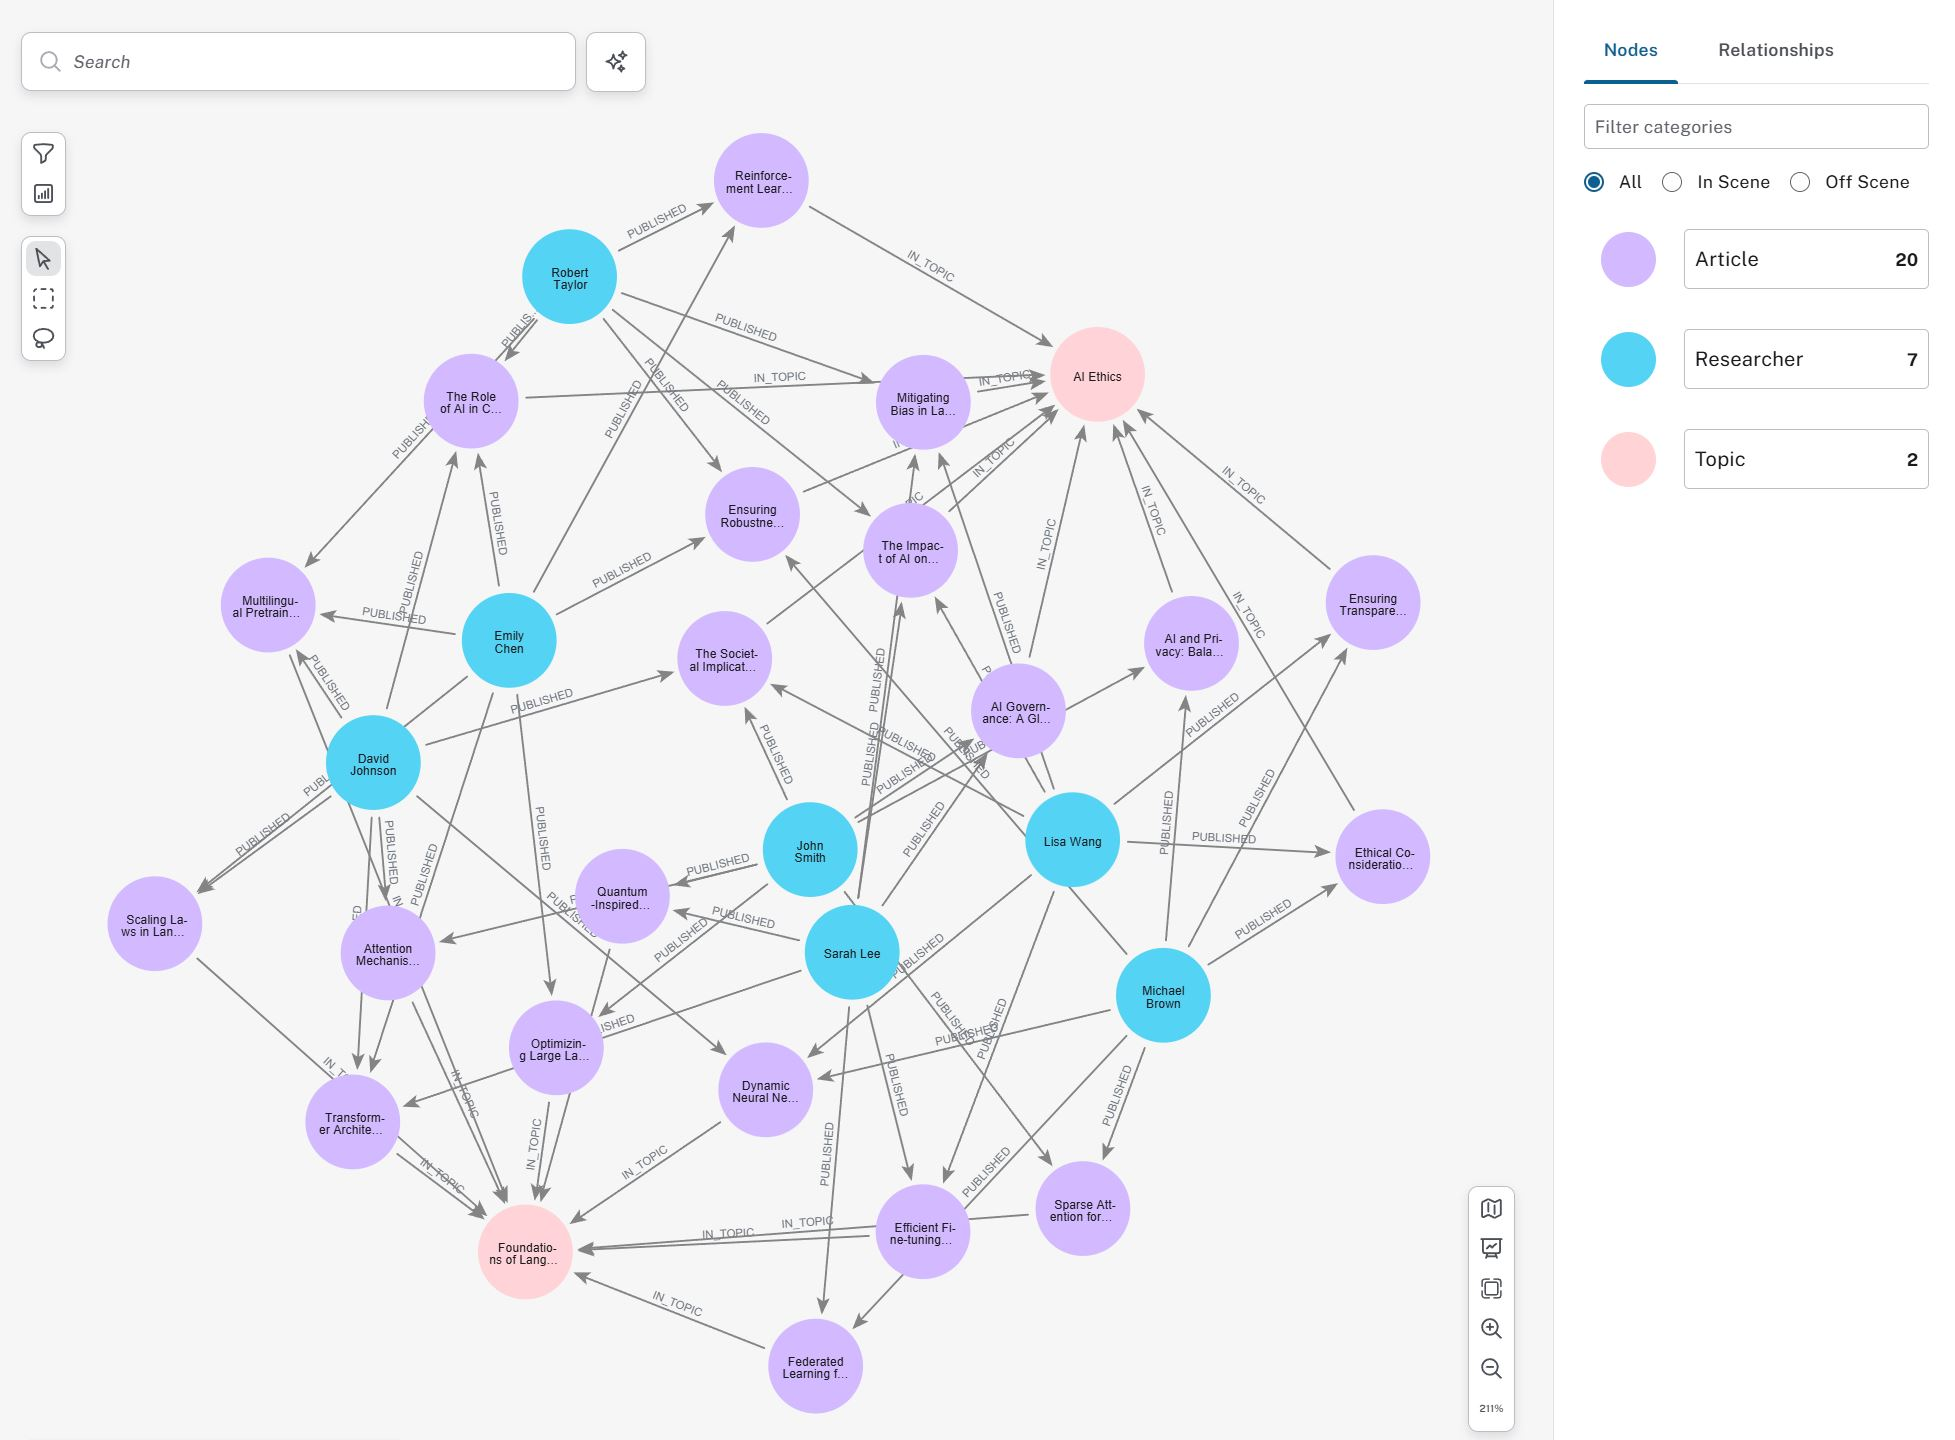

### Bulid a vector index

Now we construct a vector index to efficiently search for relevant *articles* based on their *topic*, *title* and *abstract*. This process involves calculating the embeddings for each article using these fields.

At query time, the system finds the most similar articles to the user's input by employing a similarity metric, such as cosine distance.

In [14]:
from langchain_community.vectorstores import Neo4jVector
from langchain_openai import OpenAIEmbeddings
from google.colab import userdata
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

vector_index = Neo4jVector.from_existing_graph(
    OpenAIEmbeddings(api_key=OPENAI_API_KEY),
    url=NEO4J_URI,
    username=NEO4J_USERNAME,
    password=NEO4J_PASSWORD,
    index_name='articles',
    node_label='Article',
    text_node_properties=["topic", "title", "abstract"],
    embedding_node_property="embedding",
)

With `text_node_properties=['topic', 'title', 'abstract']`, we ask LangChain to pull only those three fields from each `Article` node, concatenate their string values, and send that combined text through the embedding model.
- **Included in the embedding**
  - `topic` (if present on the node)
  - `title`
  - `abstract`
- **Not included**
  - `publication_date`

Each node ends up with a **single** embedding vector that reflects the joint content of its `topic`, `title`, and `abstract` fields.

## Q&A on similarity

We will use LangChain `RetrievalQA` to create a question-answering (QA) chain using the above vector index as a retriever.

In [15]:
from langchain.chains import RetrievalQA
from langchain_openai import ChatOpenAI

vector_qa = RetrievalQA.from_chain_type(
    llm=ChatOpenAI(api_key=OPENAI_API_KEY),
    chain_type='stuff',
    retriever=vector_index.as_retriever()
)

Now we can ask *"Which articles discuss how AI might affect our daily life?"*

In [16]:
r = vector_qa.invoke(
    {
        'query': "Which articles discuss how AI might affect our daily life? include the article titles and abstracts."
    }
)
print(r['result'])

The articles that discuss how AI might affect our daily life are:

1. **The Societal Implications of Advanced AI: A Multidisciplinary Analysis**
   - abstract: Our study brings together experts from various fields to analyze the potential long-term impacts of advanced AI on society, economy, and culture.

2. **Ethical Considerations in AI Development**
   - abstract: We explore the ethical implications of rapid AI advancement and propose guidelines for responsible development.


## Traversing knowledge graphs for inference

Knowledge graphs are excellent for making connections between entities, enabling the extraction of patterns and the discovery of new insights.

### Graph-Cypher-Chain with LangChain

To construct expressive and efficient queries, Neo4j uses Cypher, a declarative query language inpsired by SQL.

LangChain proivdes the wrapper `GraphCypherQAChain`, an abstraction layer that allows querying graph databases using natural language, making it easier to integrate graph-based data retrieval into LLM pipelines.

In general, the `GraphCypherQAChain` will
- generate Cypher statements (queries for graph databases like Neo4j) from user input (natural language) applying in-context learning (prompt engineering),
- executes said statements against a graph database, and
- provides the results as context to ground the LLM responses on accurate, up-to-date information.

This implementation involves executing model-generated graph queries, which carries inherent risks such as unintended access or modification of sensitive data in the database. To mitigate these risks, ensure that our database connection permissions are as restricted as possible to meet the specific needs of our chain/agent.

In [18]:
from langchain.chains import GraphCypherQAChain

graph.refresh_schema()

cypher_chain = GraphCypherQAChain.from_llm(
    cypher_llm=ChatOpenAI(
        api_key=OPENAI_API_KEY,
        model_name='gpt-4o',
        temperature=0
    ),
    qa_llm=ChatOpenAI(
        api_key=OPENAI_API_KEY,
        model_name='gpt-4o',
        temperature=0
    ),
    graph=graph,
    verbose=True,
    allow_dangerous_requests=True
)

### Query samples using natural language

Our question is "*How many aritcles has been published by Emily Chen?*", and this will be translated into the Cypher query:
```cypher
MATCH (r:Researcher {name: "Emily Chen"})-[:PUBLISHED]->(a:Article)
RETURN COUNT(a) AS numberOfArticles
```
which matches nodes labeled `Author` with the name `"Emily Chen"` and traverse the `PUBLISHED` relationships to `Article` nodes. It then counts the number of `Article` nodes connected to `"Emily Chen"`.

In [19]:
# correct answer should be 7
cypher_chain.invoke(
    {'query': "How many aritcles has been published by Emily Chen?"}
)



> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (:Researcher {name: "Emily Chen"})-[:PUBLISHED]->(a:Article)
RETURN COUNT(a) AS numberOfArticles

Full Context:
[{'numberOfArticles': 7}]

> Finished chain.


{'query': 'How many aritcles has been published by Emily Chen?',
 'result': 'Emily Chen has published 7 articles.'}

We can try another example,
- "Are there any pair of researchers who have published more than three articles together?"

This will be converted as
```cypher
MATCH (r1:Researcher)-[:PUBLISHED]->(a:Article)<-[:PUBLISHED]-(r2:Researcher)
WHERE r1 <> r2
WITH r1, r2, COUNT(a) AS sharedArticles
WHERE sharedArticles > 3
RETURN r1.name, r2.name, sharedArticles
```
which results in traversing from the `Researcher` nodes to the `PUBLISHED` relationship to find connected `Article` nodes, and then traversing back to find `Researcher`s pairs.

In [20]:
# correct answer should be David Johnson & Emily Chen, Robert Taylor & Emily Chen
cypher_chain.invoke(
    {'query': "Are there any pair of researchers who have published more than three articles together?"}
)



> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (r1:Researcher)-[:PUBLISHED]->(a:Article)<-[:PUBLISHED]-(r2:Researcher)
WHERE r1 <> r2
WITH r1, r2, COUNT(a) AS sharedArticles
WHERE sharedArticles > 3
RETURN r1.name, r2.name, sharedArticles

Full Context:
[{'r1.name': 'David Johnson', 'r2.name': 'Emily Chen', 'sharedArticles': 4}, {'r1.name': 'Robert Taylor', 'r2.name': 'Emily Chen', 'sharedArticles': 4}, {'r1.name': 'Emily Chen', 'r2.name': 'David Johnson', 'sharedArticles': 4}, {'r1.name': 'Emily Chen', 'r2.name': 'Robert Taylor', 'sharedArticles': 4}]

> Finished chain.


{'query': 'Are there any pair of researchers who have published more than three articles together?',
 'result': 'Yes, David Johnson and Emily Chen, as well as Robert Taylor and Emily Chen, have published more than three articles together.'}

In the last example question, we can try "Which researcher has collaborated with the most peers?" and this will be converted into
```cypher
MATCH (r:Researcher)-[:PUBLISHED]->(:Article)<-[:PUBLISHED]-(peer:Researcher)
WITH r, COUNT(DISTINCT peer) AS peerCount
RETURN r.name AS researcher, peerCount
ORDER BY peerCount DESC
LIMIT 1
```

In [21]:
# the answer should be 'David Johnson'
cypher_chain.invoke({"query": "Which researcher has collaborated with the most peers?"})



> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (r:Researcher)-[:PUBLISHED]->(:Article)<-[:PUBLISHED]-(peer:Researcher)
WITH r, COUNT(DISTINCT peer) AS peerCount
RETURN r.name AS researcher, peerCount
ORDER BY peerCount DESC
LIMIT 1

Full Context:
[{'researcher': 'David Johnson', 'peerCount': 6}]

> Finished chain.


{'query': 'Which researcher has collaborated with the most peers?',
 'result': 'David Johnson has collaborated with the most peers, with a peer count of 6.'}